In [4]:
import math
import random
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn

In [5]:
print(tf.__version__)

2.10.0


In [6]:
table = pd.read_table('./1663769555_8559356_train.txt', names=['binding','sequence'])

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
def return_binary_vectorized_form(data_frame, feat = None):
    if feat is None:
        count_vectorizer = CountVectorizer(binary=True)
    else:
        count_vectorizer = CountVectorizer(binary=True, vocabulary=feat)
    fitted_and_transformed = count_vectorizer.fit_transform(data_frame).toarray()
    return count_vectorizer,  fitted_and_transformed

In [8]:
from sklearn.feature_selection import SelectKBest, chi2
def select_k_best_features(feature_set, target_values, fraction, feature_list):
    select_bestselect_best = SelectKBest(score_func=chi2, k = int(len(feature_list)*fraction))
    select_bestselect_best.fit(feature_set,target_values)
    mask = select_bestselect_best.get_support()
    k_best_featurs = feature_list[mask]
    return k_best_featurs

In [9]:
from sklearn.model_selection import train_test_split
active_df = table.loc[table.binding == 1]
not_active_df = table.loc[table.binding == 0]
# Mainly spliting the data here for testing, that is the reason train size is set to .20
active_train, active_test, active_binding_train, active_binding_test = train_test_split(active_df.sequence, active_df.binding, shuffle=True, train_size= .82)
not_active_train, not_active_test, not_active_binding_train, not_active_binding_test = train_test_split(not_active_df.sequence, not_active_df.binding, shuffle=True, train_size=.90)

In [10]:
def createDf(data):
    pd_df = pd.DataFrame(data)
    return pd_df
def addColumn(copy_to, copy_from ,cname):
    copy_to[cname] = copy_from[cname]
    return copy_to

In [11]:
active_test_df = pd.DataFrame(active_test)
active_binding_test_df = pd.DataFrame(active_binding_test)
active_test_df['binding'] = active_binding_test_df['binding']
not_active_test_df = pd.DataFrame(not_active_test)
not_active_binding_test_df = pd.DataFrame(not_active_binding_test)
not_active_test_df['binding'] = not_active_binding_test_df['binding']
active_train_df = createDf(active_train)
active_binding_train_df = createDf(active_binding_train)
active_train_df = addColumn(active_train_df, active_binding_train_df, 'binding')
not_active_train_df = createDf(not_active_train)
not_active_binding_train_df = createDf(not_active_binding_train)
not_active_train_df = addColumn(not_active_train_df, not_active_binding_train_df, 'binding')
train_df = pd.concat([active_train_df, not_active_train_df]).reset_index()
train_df = train_df.drop('index', axis=1)
print(train_df.binding.value_counts())
test_df = pd.concat([active_test_df, not_active_test_df]).reset_index()
test_df = test_df.drop('index', axis=1)
print(test_df.binding.value_counts())
from imblearn.over_sampling import RandomOverSampler, SMOTE




0    649
1     63
Name: binding, dtype: int64
0    73
1    15
Name: binding, dtype: int64


In [61]:
sampler = RandomOverSampler()
x_sampled, y_sampled = sampler.fit_resample(np.array(train_df.sequence).reshape(-1, 1), train_df.binding)

final_train_set = pd.DataFrame(x_sampled, columns  =["sequence"])
final_train_set['binding'] = y_sampled
print(final_train_set.binding.value_counts())

final_test_set = pd.DataFrame(test_df.sequence, columns  =["sequence"])
final_test_set['binding'] = test_df.binding
print(final_test_set.binding.value_counts())

1    649
0    649
Name: binding, dtype: int64
0    73
1    15
Name: binding, dtype: int64


In [62]:
train_result = np.array(final_train_set.binding)
test_result = np.array(final_test_set.binding)

In [63]:
vectorizer_best, training_split = return_binary_vectorized_form(final_train_set.sequence)
features = select_k_best_features(training_split,train_result,.30,vectorizer_best.get_feature_names_out())

In [64]:
vectorizer_best, training_split = return_binary_vectorized_form(final_train_set.sequence,features)
test_split = vectorizer_best.transform(final_test_set.sequence).toarray()

In [67]:
# smote = SMOTE(random_state=42)
# x, y = smote.fit_resample(training_split, train_result)
# training_split = x
# train_result = y
# print(training_split.shape)
# print(test_split.shape)

In [68]:
initial_weight = np.ones(training_split.shape[0])*(1/training_split.shape[0])

In [69]:
def updateWeight(missmatch, weight, alpha):
    mi = 0
    missmatch_size = len(missmatch)
    wi = 0

    new_weight = []
    norm_constant = 0
    while wi < len(weight):
        if mi < missmatch_size and missmatch[mi] == wi:
            k = weight[wi] * math.exp(alpha)
            mi+=1
        else:
            k = weight[wi] * math.exp(-1*alpha)
        new_weight.append( k )
        norm_constant += k
        wi += 1

    new_weight /= norm_constant
    sum =0
    for i in new_weight:
        sum+=i
    print(sum)
    # plt.plot(new_weight)
    # plt.show()
    return new_weight

In [70]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
def findMissClassificatonIndex(predicted, test_res, weight):
    error_rate = 0
    missmatch_indexes = []
    incorrect= []
    tn, fp, fn, tp = confusion_matrix(test_res, predicted).ravel()
    precision = tp / (tp+ fp)
    recall = tp / (tp+ fn)
    score = (2 * precision * recall) / (precision + recall)
    print(score)
    print(accuracy_score(test_res, predicted))
    for i, (pred, real) in enumerate(zip(predicted, test_res)):
        if pred != real:
            incorrect.append((i, pred, real))
            missmatch_indexes.append(i)
            error_rate += weight[i]
    error_rate /= len(predicted)
    # print(incorrect)
    return error_rate, missmatch_indexes

In [71]:
def rejectionSampling(train_data, train_res, weights):
    samplesize  = int(4 * len(train_data))
    new_train_data = []
    new_train_res = []
    new_weights = []
    adding_index =[]
    max_w = max(weights)

    for i in range(samplesize):
        while True:
            index = random.randrange(len(weights))
            u = max_w * random.random()
            if u <= weights[index]:
                new_train_data.append(train_data[index])
                new_train_res.append(train_res[index])
                adding_index.append(index)
                break
    # print(adding_index)
    return np.array(new_train_data), np.array(new_train_res)

In [72]:
def resample(train_data, train_res, weights):
    size = len(train_data)
    indexes = np.random.choice(int(size), int( 5 * size), replace=True, p=weights)
    new_train_data = []
    new_train_res = []
    for index in indexes:
         new_train_data.append(train_data[index])
         new_train_res.append(train_res[index])
    return np.array(new_train_data), np.array(new_train_res)

In [73]:
class EarlyStoppingMonitor(tf.keras.callbacks.Callback):
    def __init__(self):
        super(EarlyStoppingMonitor, self).__init__()
        self.f1_train = None
        self.f1_test = None
        self.prevous = None
        self.count =0

    def on_epoch_end(self, epoch, logs=None):
        current_train_precision = logs.get('precision')
        current_train_recall= logs.get('recall')

        if current_train_precision==0 or current_train_recall==0:
            print("**** Waring: precision recall zero avoid exception ****")
            return
        self.f1_train = (2*current_train_precision*current_train_recall) / (current_train_precision+current_train_recall)
        if self.prevous == None:
            self.prevous = self.f1_train
        if self.prevous == self.f1_train:
            self.count += 1
        else:
            self.prevous = self.f1_train
            self.count = 0
        if self.count == 5:
            self.model.stop_training = True
            print('\n\n******* No improvements *******')
        if current_train_recall > .45:
            # self.count += 1
            # if self.count >4:
            self.model.stop_training = True
            print('\n\n******* Stoping on Defined Thresold *******')
            print('F1 TRAINING: ', self.f1_train)
            print('Recall TRAINING: ', current_train_recall)

    def on_train_end(self, logs=None):
        if self.model.stop_training:
            print("\n\n\n****** Early Stopping *******")

In [74]:
def createBaseModel():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(training_split.shape[-1],)),
        tf.keras.layers.Dense(2, activation='relu',kernel_regularizer=tf.keras.regularizers.L1(.025)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(), metrics=METRICS, optimizer='adam')

    return model

In [75]:
ensemble_size = 12
ensemble = []
alphas = []
def boosting(weights):

    for i in range(ensemble_size):
        print(" =========== iteration ===========>:", i )
        train_data, train_res = resample(training_split, train_result, weights)
        model = createBaseModel()
        num_epochs = 60
        print( "bfore traning: ", ((sum(train_res)/len(train_res)))*100)
        history = model.fit(train_data, train_res,
                    epochs= num_epochs,
                    batch_size=70,
                    callbacks=[EarlyStoppingMonitor()])
        predicted_result = model.predict(training_split)
        predicted_result = [1 if i>=.5 else 0 for i in predicted_result ]
        error_rate, error_indexes = findMissClassificatonIndex(predicted_result, train_result, weights)
        print("error_rate:", error_rate)

        if error_rate > .5:
            weights = np.ones(training_split.shape[0]) * (1/training_split.shape[0])
            print("re-balancing and training because error:", error_rate)
            continue

        amount_of_say = 0.025 * ( math.log( (1-error_rate) / error_rate ) )
        alphas.append(amount_of_say)
        ensemble.append(model)
        weights = updateWeight(error_indexes, weights, amount_of_say)


In [76]:
# plt.plot(initial_weight)
boosting(initial_weight)

 =========== iteration ===========>: 0
bfore traning:  50.40061633281972
Epoch 1/60


2022-11-13 00:15:32.928791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - ETA: 0s - loss: 1.1616 - tp: 2314.0000 - fp: 196.0000 - tn: 3023.0000 - fn: 957.0000 - precision: 0.9219 - recall: 0.7074

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.8005535528424954
Recall TRAINING:  0.7074289321899414
93/93 [==============================] - 3s 19ms/step - loss: 1.1616 - tp: 2314.0000 - fp: 196.0000 - tn: 3023.0000 - fn: 957.0000 - precision: 0.9219 - recall: 0.7074



****** Early Stopping *******
41/41 [==============================] - 0s 4ms/step


2022-11-13 00:15:35.444232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.6800401203610832
0.7542372881355932
error_rate: 0.00018933953148259286
0.9999999999999774
 =========== iteration ===========>: 1
bfore traning:  54.60708782742682
Epoch 1/60


2022-11-13 00:15:36.678427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - ETA: 0s - loss: 1.1600 - tp: 3385.0000 - fp: 1144.0000 - tn: 1802.0000 - fn: 159.0000 - precision: 0.7474 - recall: 0.9551

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.8385977921732173
Recall TRAINING:  0.9551354646682739
93/93 [==============================] - 3s 20ms/step - loss: 1.1600 - tp: 3385.0000 - fp: 1144.0000 - tn: 1802.0000 - fn: 159.0000 - precision: 0.7474 - recall: 0.9551



****** Early Stopping *******
41/41 [==============================] - 0s 4ms/step


2022-11-13 00:15:39.180045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.9420062695924765
0.9429892141756548
error_rate: 5.481644836889323e-05
0.9999999999999732
 =========== iteration ===========>: 2
bfore traning:  56.009244992295834
Epoch 1/60


2022-11-13 00:15:40.338029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - ETA: 0s - loss: 1.1613 - tp: 3104.0000 - fp: 193.0000 - tn: 2662.0000 - fn: 531.0000 - precision: 0.9415 - recall: 0.8539

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.8955568320444797
Recall TRAINING:  0.8539202213287354
93/93 [==============================] - 3s 21ms/step - loss: 1.1613 - tp: 3104.0000 - fp: 193.0000 - tn: 2662.0000 - fn: 531.0000 - precision: 0.9415 - recall: 0.8539



****** Early Stopping *******
41/41 [==============================] - 0s 4ms/step


2022-11-13 00:15:42.966155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.9056603773584906
0.911402157164869
error_rate: 9.15654149184749e-05
1.0000000000000098
 =========== iteration ===========>: 3
bfore traning:  56.85670261941448
Epoch 1/60


2022-11-13 00:15:44.190143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - ETA: 0s - loss: 1.1500 - tp: 3628.0000 - fp: 2415.0000 - tn: 385.0000 - fn: 62.0000 - precision: 0.6004 - recall: 0.9832

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.7455050004586017
Recall TRAINING:  0.983197808265686
93/93 [==============================] - 3s 21ms/step - loss: 1.1500 - tp: 3628.0000 - fp: 2415.0000 - tn: 385.0000 - fn: 62.0000 - precision: 0.6004 - recall: 0.9832



****** Early Stopping *******
27/41 [==================>...........] - ETA: 0s

2022-11-13 00:15:46.753462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 4ms/step
0.8047117172969622
0.7573189522342064
error_rate: 0.00016917619820730923
0.9999999999999776
 =========== iteration ===========>: 4
bfore traning:  51.84899845916795
Epoch 1/60


2022-11-13 00:15:48.065444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - ETA: 0s - loss: 1.1574 - tp: 3065.0000 - fp: 608.0000 - tn: 2517.0000 - fn: 300.0000 - precision: 0.8345 - recall: 0.9108

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.8709860901144987
Recall TRAINING:  0.9108469486236572
93/93 [==============================] - 3s 21ms/step - loss: 1.1574 - tp: 3065.0000 - fp: 608.0000 - tn: 2517.0000 - fn: 300.0000 - precision: 0.8345 - recall: 0.9108



****** Early Stopping *******
41/41 [==============================] - 0s 4ms/step


2022-11-13 00:15:50.647514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.9552941176470587
0.9560862865947611
error_rate: 6.998918072044037e-05
0.9999999999999946
 =========== iteration ===========>: 5
bfore traning:  51.34052388289676
Epoch 1/60


2022-11-13 00:15:51.941122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - ETA: 0s - loss: 1.1566 - tp: 3069.0000 - fp: 1237.0000 - tn: 1921.0000 - fn: 263.0000 - precision: 0.7127 - recall: 0.9211

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.8036135261349862
Recall TRAINING:  0.9210684895515442
93/93 [==============================] - 3s 20ms/step - loss: 1.1566 - tp: 3069.0000 - fp: 1237.0000 - tn: 1921.0000 - fn: 263.0000 - precision: 0.7127 - recall: 0.9211



****** Early Stopping *******
41/41 [==============================] - 0s 4ms/step


2022-11-13 00:15:54.447788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.924846625766871
0.9244992295839753
error_rate: 0.00010053130531242611
0.9999999999999805
 =========== iteration ===========>: 6
bfore traning:  50.44684129429891
Epoch 1/60


2022-11-13 00:15:55.747263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - ETA: 0s - loss: 1.1584 - tp: 2590.0000 - fp: 228.0000 - tn: 2988.0000 - fn: 684.0000 - precision: 0.9191 - recall: 0.7911

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.8502954834928278
Recall TRAINING:  0.7910812497138977
93/93 [==============================] - 3s 20ms/step - loss: 1.1584 - tp: 2590.0000 - fp: 228.0000 - tn: 2988.0000 - fn: 684.0000 - precision: 0.9191 - recall: 0.7911



****** Early Stopping *******
25/41 [=================>............] - ETA: 0s

2022-11-13 00:15:58.215309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 4ms/step
0.6954773869346733
0.7665639445300462
error_rate: 0.00017976832348149717
0.9999999999999867
 =========== iteration ===========>: 7
bfore traning:  56.88751926040062
Epoch 1/60


2022-11-13 00:15:59.540373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - ETA: 0s - loss: 1.1504 - tp: 3440.0000 - fp: 1788.0000 - tn: 1010.0000 - fn: 252.0000 - precision: 0.6580 - recall: 0.9317

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.771300452535014
Recall TRAINING:  0.9317443370819092
93/93 [==============================] - 3s 20ms/step - loss: 1.1504 - tp: 3440.0000 - fp: 1788.0000 - tn: 1010.0000 - fn: 252.0000 - precision: 0.6580 - recall: 0.9317



****** Early Stopping *******
27/41 [==================>...........] - ETA: 0s

2022-11-13 00:16:02.091893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 4ms/step
0.6666666666666666
0.5
error_rate: 0.00033627453214757445
0.9999999999999919
 =========== iteration ===========>: 8
bfore traning:  46.08628659476117
Epoch 1/60


2022-11-13 00:16:03.435133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - 3s 20ms/step - loss: 1.1733 - tp: 1013.0000 - fp: 70.0000 - tn: 3429.0000 - fn: 1978.0000 - precision: 0.9354 - recall: 0.3387
Epoch 2/60
93/93 [==============================] - 1s 14ms/step - loss: 0.3415 - tp: 849.0000 - fp: 2.0000 - tn: 3497.0000 - fn: 2142.0000 - precision: 0.9976 - recall: 0.2839
Epoch 3/60
93/93 [==============================] - 1s 14ms/step - loss: 0.3413 - tp: 1226.0000 - fp: 3.0000 - tn: 3496.0000 - fn: 1765.0000 - precision: 0.9976 - recall: 0.4099
Epoch 4/60
93/93 [==============================] - ETA: 0s - loss: 0.3419 - tp: 1539.0000 - fp: 20.0000 - tn: 3479.0000 - fn: 1452.0000 - precision: 0.9872 - recall: 0.5145

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.6764834904068678
Recall TRAINING:  0.5145435929298401
93/93 [==============================] - 1s 13ms/step - loss: 0.3419 - tp: 1539.0000 - fp: 20.0000 - tn: 3479.0000 - fn: 1452.0000 - precision: 0.9872 - recall: 0.5145



****** Early Stop

2022-11-13 00:16:09.729369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.8361683079677708
0.8590138674884438
error_rate: 0.00013665384583313753
1.000000000000018
 =========== iteration ===========>: 9
bfore traning:  50.708782742681045
Epoch 1/60


2022-11-13 00:16:11.018975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - ETA: 0s - loss: 1.1532 - tp: 3071.0000 - fp: 693.0000 - tn: 2506.0000 - fn: 220.0000 - precision: 0.8159 - recall: 0.9332

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.8705882179304345
Recall TRAINING:  0.9331510066986084
93/93 [==============================] - 3s 21ms/step - loss: 1.1532 - tp: 3071.0000 - fp: 693.0000 - tn: 2506.0000 - fn: 220.0000 - precision: 0.8159 - recall: 0.9332



****** Early Stopping *******
41/41 [==============================] - ETA: 0s

2022-11-13 00:16:13.558818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 4ms/step
0.81686595342983
0.775808936825886
error_rate: 0.0001934314117433021
0.9999999999999829
 =========== iteration ===========>: 10
bfore traning:  45.932203389830505
Epoch 1/60


2022-11-13 00:16:16.028859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - 4s 19ms/step - loss: 1.1609 - tp: 1274.0000 - fp: 101.0000 - tn: 3408.0000 - fn: 1707.0000 - precision: 0.9265 - recall: 0.4274
Epoch 2/60
93/93 [==============================] - 1s 13ms/step - loss: 0.3394 - tp: 517.0000 - fp: 0.0000e+00 - tn: 3509.0000 - fn: 2464.0000 - precision: 1.0000 - recall: 0.1734
Epoch 3/60
93/93 [==============================] - 1s 12ms/step - loss: 0.3403 - tp: 839.0000 - fp: 1.0000 - tn: 3508.0000 - fn: 2142.0000 - precision: 0.9988 - recall: 0.2814
Epoch 4/60
92/93 [============================>.] - ETA: 0s - loss: 0.3400 - tp: 1336.0000 - fp: 4.0000 - tn: 3474.0000 - fn: 1626.0000 - precision: 0.9970 - recall: 0.4510

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.621247127187088
Recall TRAINING:  0.45119088888168335
93/93 [==============================] - 1s 12ms/step - loss: 0.3399 - tp: 1345.0000 - fp: 4.0000 - tn: 3505.0000 - fn: 1636.0000 - precision: 0.9970 - recall: 0.4512



****** Early St

2022-11-13 00:16:21.918957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.4959443800695249
0.6648690292758089
error_rate: 0.0002336081259188377
0.9999999999999982
 =========== iteration ===========>: 11
bfore traning:  51.69491525423729
Epoch 1/60


2022-11-13 00:16:23.086820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - ETA: 0s - loss: 1.1544 - tp: 2949.0000 - fp: 860.0000 - tn: 2275.0000 - fn: 406.0000 - precision: 0.7742 - recall: 0.8790

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.8232830985040639
Recall TRAINING:  0.8789865970611572
93/93 [==============================] - 3s 20ms/step - loss: 1.1544 - tp: 2949.0000 - fp: 860.0000 - tn: 2275.0000 - fn: 406.0000 - precision: 0.7742 - recall: 0.8790



****** Early Stopping *******
41/41 [==============================] - 0s 4ms/step
0.6896918172157279
0.5500770416024653
error_rate: 0.0003211193038836449
1.0000000000000084


2022-11-13 00:16:25.619619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [77]:
alphas

[0.2142944833571189,
 0.2452866359594811,
 0.23245913385913086,
 0.21711001506777447,
 0.23917749743418018,
 0.23012352117412216,
 0.21559154608434536,
 0.1999311585141182,
 0.2224480709781944,
 0.21375985298708994,
 0.20904079716467994,
 0.2010844167455315]

In [78]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


def repeat(test_split, test_result, start, end):
    mx = 0
    size = 0
    data = []
    f1=[]
    for i in range(start,end):
        data = some_pred(test_split, i)
        tn, fp, fn, tp = confusion_matrix(test_result, data).ravel()
        precision = tp / (tp+ fp)
        recall = tp / (tp+ fn)
        score = (2 * precision * recall) / (precision + recall)
        print(score)
        f1.append(score)
        if mx < score:
            mx = score
            size = i
        print(i)
    print(mx,size)
    return data, f1

# a = ensemble[0].predict(test_split)

def some_pred(test_split, esize):
#     data = []
    k = []
#     for j in range(len(test_split)):
#         pa=0
#         na =0
    for i in range(esize):
        print('*********:', i)
        k.append(ensemble[i].predict([test_split]))
        # if pa >=na:
        #     data.append(1)
        # else:
        #     data.append(0)
    # f1.append(f1_score(test_result, data, average="macro"))
    # acc.append(accuracy_score(test_result, data))
    return k

In [79]:

def majority(data):
    ans =[]
    for i in range(len(data[0])):
        ap = 0
        an = 0
        for e in range(len(data)):
            if data[e][i] >= .5:
                ap += alphas[e]
            else:
                an += alphas[e]
        if ap >= an:
            ans.append(1)
        else:
            ans.append(0)
    return ans


In [80]:
def getf1(true, predicted):
    tn, fp, fn, tp = confusion_matrix(true, predicted).ravel()
    precision = tp / (tp+ fp)
    recall = tp / (tp+ fn)
    score = (2 * precision * recall) / (precision + recall)
    return score

In [81]:
f1_test = []
for i in range(1,13):
    data = some_pred(test_split, i)
    ans = majority(data)
    f1_test.append(getf1(test_result, ans))
    # ConfusionMatrixDisplay.from_predictions(test_result,ans,cmap='Greens')

*********: 0
3/3 [==============================] - 0s 27ms/step
*********: 0
3/3 [==============================] - 0s 6ms/step
*********: 1


2022-11-13 00:25:27.416415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:25:27.599368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 18ms/step
*********: 0
3/3 [==============================] - 0s 6ms/step
*********: 1
3/3 [==============================] - 0s 3ms/step
*********: 2
3/3 [==============================] - 0s 13ms/step
*********: 0
3/3 [==============================] - 0s 9ms/step
*********: 1
3/3 [==============================] - 0s 7ms/step


2022-11-13 00:25:27.810874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
3/3 [==============================] - 0s 3ms/step
*********: 3
3/3 [==============================] - 0s 20ms/step
*********: 0
3/3 [==============================] - 0s 6ms/step
*********: 1
3/3 [==============================] - 0s 5ms/step


2022-11-13 00:25:28.059754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
3/3 [==============================] - 0s 7ms/step
*********: 3
3/3 [==============================] - 0s 7ms/step
*********: 4
3/3 [==============================] - 0s 16ms/step
*********: 0
3/3 [==============================] - 0s 3ms/step
*********: 1
3/3 [==============================] - 0s 6ms/step
*********: 2
3/3 [==============================] - 0s 7ms/step


2022-11-13 00:25:28.376611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 3
3/3 [==============================] - 0s 4ms/step
*********: 4
3/3 [==============================] - 0s 6ms/step
*********: 5
3/3 [==============================] - 0s 16ms/step
*********: 0
3/3 [==============================] - 0s 3ms/step
*********: 1
3/3 [==============================] - 0s 4ms/step
*********: 2
1/3 [=========>....................] - ETA: 0s

2022-11-13 00:25:28.711027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 7ms/step
*********: 3
3/3 [==============================] - 0s 8ms/step
*********: 4
3/3 [==============================] - 0s 4ms/step
*********: 5
3/3 [==============================] - 0s 9ms/step
*********: 6
3/3 [==============================] - 0s 13ms/step
*********: 0
3/3 [==============================] - 0s 4ms/step
*********: 1
3/3 [==============================] - 0s 3ms/step
*********: 2
3/3 [==============================] - 0s 3ms/step


2022-11-13 00:25:29.118507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 3
3/3 [==============================] - 0s 3ms/step
*********: 4
3/3 [==============================] - 0s 3ms/step
*********: 5
3/3 [==============================] - 0s 8ms/step
*********: 6
3/3 [==============================] - 0s 7ms/step
*********: 7
3/3 [==============================] - 0s 19ms/step
*********: 0
3/3 [==============================] - 0s 3ms/step
*********: 1
3/3 [==============================] - 0s 6ms/step
*********: 2
3/3 [==============================] - 0s 3ms/step


2022-11-13 00:25:29.526670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 3
3/3 [==============================] - 0s 3ms/step
*********: 4
3/3 [==============================] - 0s 4ms/step
*********: 5
3/3 [==============================] - 0s 3ms/step
*********: 6
3/3 [==============================] - 0s 3ms/step
*********: 7
3/3 [==============================] - 0s 4ms/step
*********: 8
3/3 [==============================] - 0s 16ms/step
*********: 0
3/3 [==============================] - 0s 3ms/step
*********: 1
3/3 [==============================] - 0s 3ms/step
*********: 2
3/3 [==============================] - 0s 3ms/step


2022-11-13 00:25:29.987020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 3
3/3 [==============================] - 0s 3ms/step
*********: 4
3/3 [==============================] - 0s 5ms/step
*********: 5
3/3 [==============================] - 0s 4ms/step
*********: 6
3/3 [==============================] - 0s 6ms/step
*********: 7
3/3 [==============================] - 0s 7ms/step
*********: 8
3/3 [==============================] - 0s 7ms/step
*********: 9
3/3 [==============================] - 0s 13ms/step
*********: 0
3/3 [==============================] - 0s 3ms/step
*********: 1
3/3 [==============================] - 0s 3ms/step
*********: 2
3/3 [==============================] - 0s 3ms/step


2022-11-13 00:25:30.477729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 3
3/3 [==============================] - 0s 3ms/step
*********: 4
3/3 [==============================] - 0s 4ms/step
*********: 5
3/3 [==============================] - 0s 4ms/step
*********: 6
3/3 [==============================] - 0s 6ms/step
*********: 7
3/3 [==============================] - 0s 7ms/step
*********: 8
3/3 [==============================] - 0s 9ms/step
*********: 9
3/3 [==============================] - 0s 3ms/step
*********: 10
3/3 [==============================] - 0s 12ms/step
*********: 0
3/3 [==============================] - 0s 3ms/step
*********: 1
3/3 [==============================] - 0s 3ms/step
*********: 2
3/3 [==============================] - 0s 3ms/step


2022-11-13 00:25:31.019166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 3
3/3 [==============================] - 0s 6ms/step
*********: 4
3/3 [==============================] - 0s 5ms/step
*********: 5
3/3 [==============================] - 0s 3ms/step
*********: 6
3/3 [==============================] - 0s 4ms/step
*********: 7
3/3 [==============================] - 0s 3ms/step
*********: 8
3/3 [==============================] - 0s 4ms/step
*********: 9
3/3 [==============================] - 0s 9ms/step
*********: 10
3/3 [==============================] - 0s 7ms/step
*********: 11
3/3 [==============================] - 0s 20ms/step


2022-11-13 00:25:31.598019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


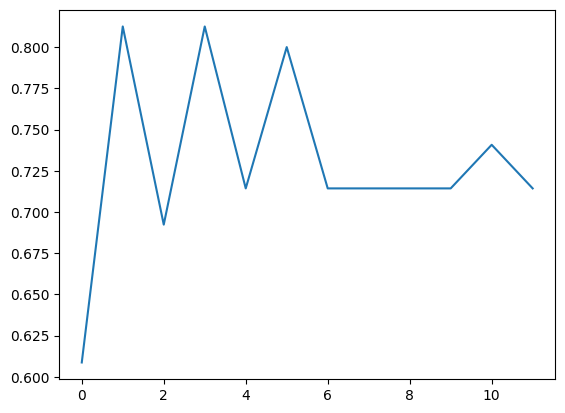

In [82]:
plt.plot(f1_test)

*********: 0
3/3 [==============================] - 0s 6ms/step
*********: 1
3/3 [==============================] - 0s 4ms/step
*********: 2
3/3 [==============================] - 0s 5ms/step
*********: 3
3/3 [==============================] - 0s 3ms/step


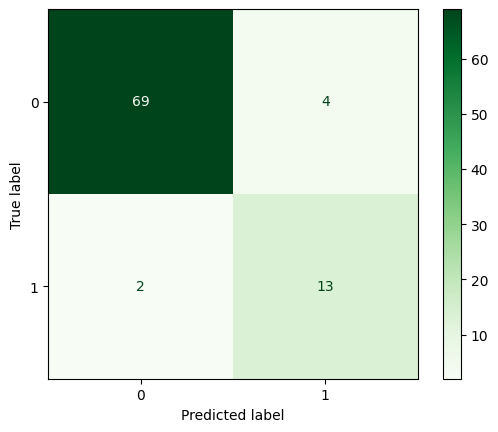

In [86]:
data = some_pred(test_split, 4)
ans = majority(data)
ConfusionMatrixDisplay.from_predictions(test_result,ans,cmap='Greens')
# plt.plot(f1_test)

In [83]:
f1_train = []
for i in range(1,13):
    data = some_pred(training_split, i)
    ans = majority(data)
    f1_train.append(getf1(train_result, ans))
    # ConfusionMatrixDisplay.from_predictions(test_result,ans,cmap='Greens')

*********: 0
41/41 [==============================] - 0s 3ms/step
*********: 0
41/41 [==============================] - 0s 3ms/step
*********: 1
41/41 [==============================] - 0s 3ms/step
*********: 0
41/41 [==============================] - 0s 3ms/step
*********: 1
41/41 [==============================] - 0s 3ms/step
*********: 2
41/41 [==============================] - 0s 4ms/step
*********: 0
41/41 [==============================] - 0s 3ms/step
*********: 1
41/41 [==============================] - 0s 3ms/step
*********: 2
41/41 [==============================] - 0s 3ms/step
*********: 3
41/41 [==============================] - 0s 3ms/step
*********: 0
41/41 [==============================] - 0s 3ms/step
*********: 1
41/41 [==============================] - 0s 2ms/step
*********: 2
41/41 [==============================] - 0s 3ms/step
*********: 3
41/41 [==============================] - 0s 3ms/step
*********: 4
41/41 [==============================] - 0s 3ms/step
*********:

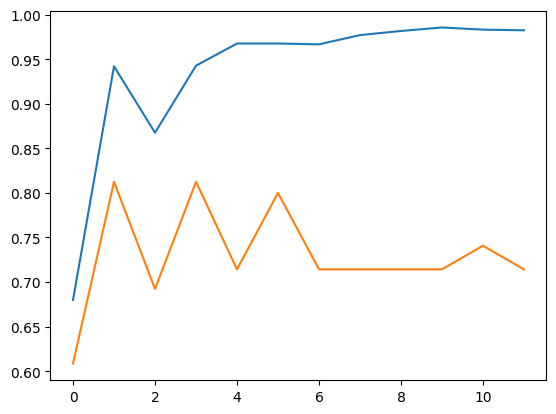

In [84]:
plt.plot(f1_train)
plt.plot(f1_test)

*********: 0
41/41 [==============================] - 0s 3ms/step
*********: 1
41/41 [==============================] - 0s 3ms/step
*********: 2
41/41 [==============================] - 0s 3ms/step
*********: 3
41/41 [==============================] - 0s 3ms/step


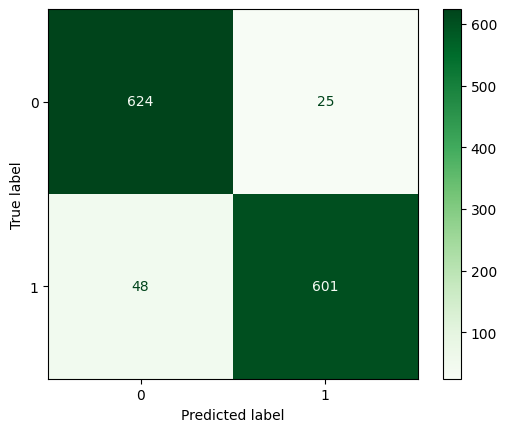

In [85]:
data = some_pred(training_split, 4)
ans = majority(data)
ConfusionMatrixDisplay.from_predictions(train_result,ans,cmap='Greens')

In [87]:
table_test = pd.read_table('./1663769555_8653905_test.txt', names=['sequence'])
unlabeled_test = vectorizer_best.transform(table_test.sequence).toarray()
predicted_data = majority(some_pred(unlabeled_test, 4))

*********: 0
11/11 [==============================] - 0s 8ms/step
*********: 1
11/11 [==============================] - 0s 5ms/step
*********: 2
11/11 [==============================] - 0s 5ms/step
*********: 3
11/11 [==============================] - 0s 5ms/step


In [88]:
import csv
outfile = open('./results.csv','w')
out = csv.writer(outfile)
out.writerows(map(lambda x: [x], predicted_data))
outfile.close()

350